In [4]:
import requests
import json
import pandas as pd
import replicate
from PIL import Image
import numpy as np
from ultralytics import YOLO
import cv2
# load env
from dotenv import load_dotenv
from fastapi import APIRouter, File, UploadFile, HTTPException
from pydantic import BaseModel, Field
from typing import Optional, List
from datetime import datetime

load_dotenv()
from src.detection.utils import run_detection_from_array, read_imagefile
from src.detection.category_utils import CATIDX_2_FR_CATNAME, CATIDX_2_EMOJI


In [5]:
# list env variables
import os

print(os.environ)

environ({'ALLUSERSPROFILE': 'C:\\ProgramData', 'APPDATA': 'C:\\Users\\CYTech Student\\AppData\\Roaming', 'ASL.LOG': 'Destination=file', 'CHOCOLATEYINSTALL': 'C:\\ProgramData\\chocolatey', 'CHOCOLATEYLASTPATHUPDATE': '133096054739505066', 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'COMPUTERNAME': 'PC-MLAMALI', 'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe', 'CONDA_DEFAULT_ENV': 'keskia_env', 'CONDA_PREFIX': 'H:\\anaconda3\\envs\\keskia_env', 'CONDA_PROMPT_MODIFIER': '(keskia_env) ', 'CONDA_SHLVL': '1', 'DART_SDK': 'C:\\Program Files\\Dart\\dart-sdk', 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData', 'HOMEDRIVE': 'C:', 'HOMEPATH': '\\Users\\CYTech Student', 'IDEA_INITIAL_DIRECTORY': 'C:\\Users\\CYTech Student\\AppData\\Local\\Programs\\PyCharm Professional\\bin', 'LANG': 'en_US.UTF-8', 'LANGUAGE': '', 'LC_ALL': 'en_US.UTF-8', 'LOCALAPPDATA': 'C

## Detection pipeline


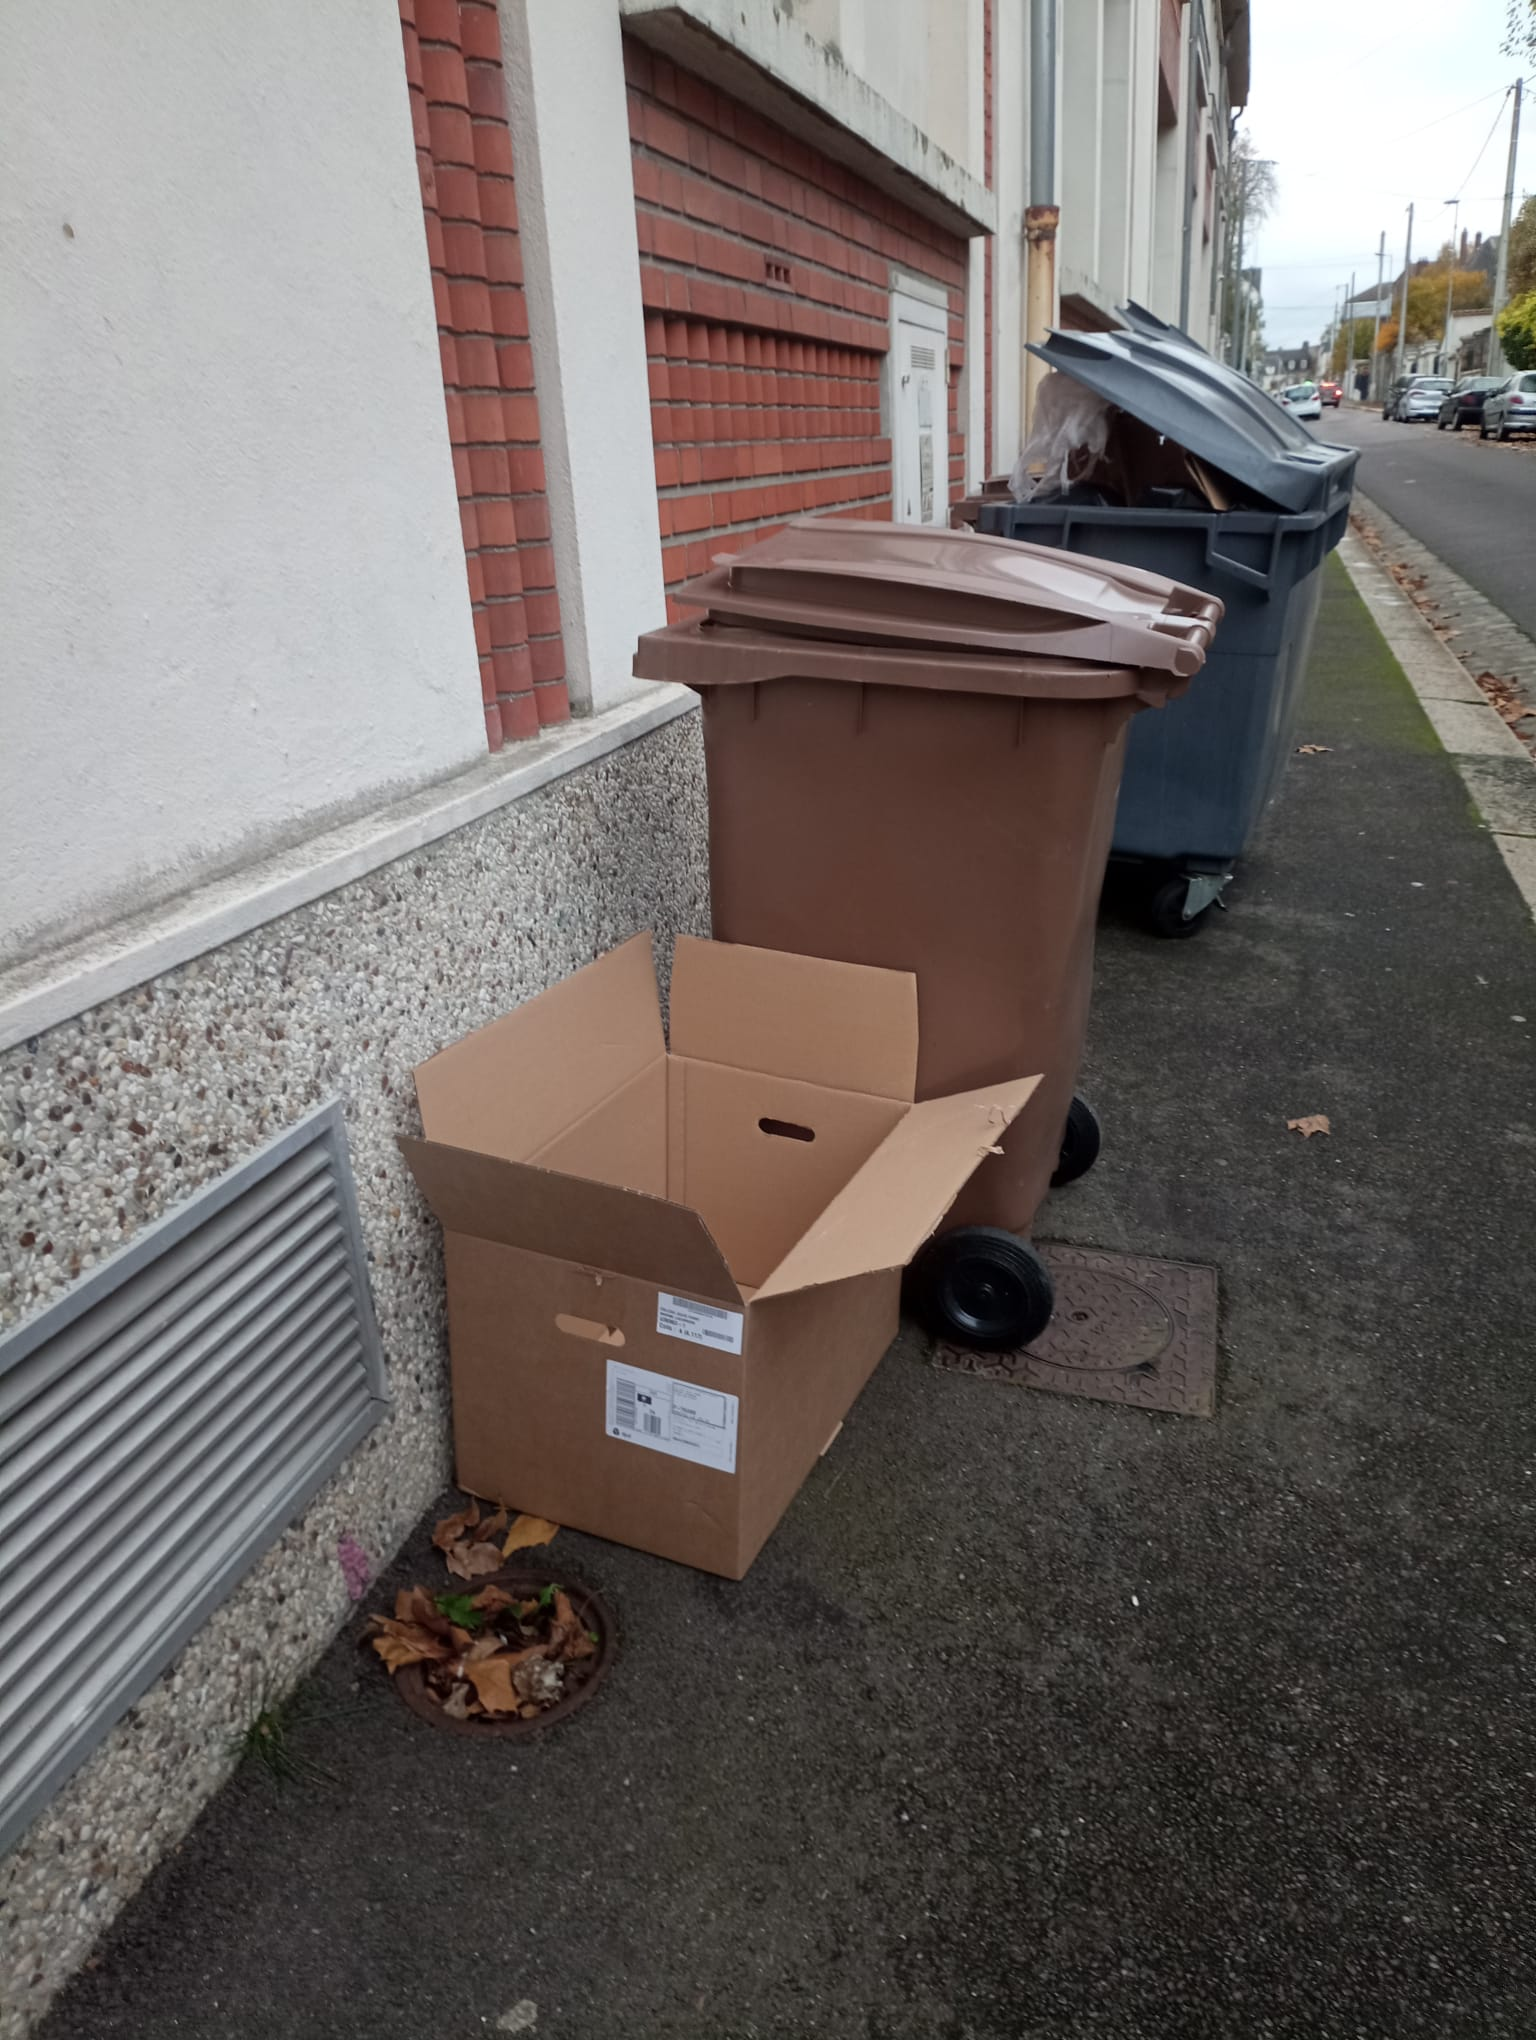

In [13]:
image_path = "../assets/raw image for demo/mantes (14).JPG"
image = Image.open(image_path)
image

In [14]:
image.tobytes()

### Input

In [ ]:
class DetectionRequest(BaseModel):
    file: UploadFile = File(..., description="Image à analyser.")
    confidence: float = Field(0.5, ge=0, le=1, description="Confidence threshold for the predictions.")
    limit: Optional[int] = Field(None, ge=1, description="Maximum number of predictions to return.")
    date: datetime = Field(default_factory=datetime.now, description="Date de la détection.")


# exemple
dr = DetectionRequest(file=UploadFile(file=image_path), confidence=0.5)

dr

### Apply

In [ ]:
bgr_image_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
output_detections, save_dir = run_detection_from_array(bgr_image_np, confidence_threshold=dr.confidence)

In [ ]:
n_detected = len(output_detections.boxes)
print(f"Detected {n_detected} objects")
output_image_path = os.path.join(save_dir, "image0.jpg")

# Charger l'image avec OpenCV
output_image = Image.open(output_image_path)
Image.open(output_image_path)

In [ ]:
output_image_bytes: bytes = Image.open(output_image_path).tobytes(encoder_name="utf")
output_image_bytes

In [ ]:
# bytes to 

In [ ]:
for i_det, box in enumerate(output_detections.boxes):
    print("#" * 10, f"Object {i_det}: {box}")


### Output

In [ ]:
class ObjectDetection(BaseModel):
    cls: int = Field(..., description="Class of the object detected.")
    x1: float = Field(..., description="x1 coordinate of the bounding box.")
    y1: float = Field(..., description="y1 coordinate of the bounding box.")
    x2: float = Field(..., description="x2 coordinate of the bounding box.")
    y2: float = Field(..., description="y2 coordinate of the bounding box.")
    confidence: float = Field(..., description="Confidence of the prediction.", ge=0, le=1)


def yolo_boxes_to_list(boxes) -> List[ObjectDetection]:
    
    result = []
    if boxes is None:
        return result
    for i_det, box in enumerate(boxes):
        xyxy = box.xywh.cpu().numpy().flatten()  # Aplatir le tableau
        x1, y1, x2, y2 = xyxy[0], xyxy[1], xyxy[2], xyxy[3]

        cls = int(box.cls.cpu().numpy().item())
        conf = box.conf.cpu().numpy().item()

        result.append(ObjectDetection(cls=cls, x1=x1, y1=y1, x2=x2, y2=y2, confidence=conf))
    return result


class DetectionResponse(BaseModel):
    count : int 
    detections: List[ObjectDetection]
    date: datetime = Field(default_factory=datetime.now, description="Date de la détection.")


DetectionResponse(detections=yolo_boxes_to_list(output_detections.boxes))

In [ ]:
## API

In [ ]:
## AP

## BaseRow  



In [6]:
def make_req(url, method="GET", verbose=False, **kwargs):
    """
    Make a request
    """
    # check if headers are passed
    if "headers" not in kwargs:
        kwargs["headers"] = {
            "Authorization": f"Token {os.environ['BASEROW_DB_API_TOKEN']}"
        }
    else:
        kwargs["headers"]["Authorization"] = f"Token {os.environ['BASEROW_DB_API_TOKEN']}"
    r = requests.request(method, url, **kwargs)
    if r.status_code == 200:
        print("Success!") if verbose else None
    else:
        raise Exception("Error!", f"{r.status_code} {r.text}")

    return r.json()


def get_list_rows():
    """
    Get all rows from the dechets table
    """
    return make_req("https://api.baserow.io/api/database/rows/table/234485/?user_field_names=true")


rows = get_list_rows()

# beatify json

print(json.dumps(rows, indent=4, sort_keys=True))

{
    "count": 18,
    "next": null,
    "previous": null,
    "results": [
        {
            "Latitude": "48.95009294382284",
            "Longitude": "1.738609673069398",
            "capture_date": "2023-11-20T09:44:49Z",
            "cat_idx_preds": [
                {
                    "id": 8,
                    "value": "7"
                },
                {
                    "id": 10,
                    "value": "9"
                },
                {
                    "id": 28,
                    "value": "27"
                },
                {
                    "id": 37,
                    "value": "36"
                }
            ],
            "description": "ordures",
            "id": 1,
            "location": "[48.95009294382284, 1.738609673069398]",
            "name": "b74c4398-8c18-4b85-9b40-d4af0d4ca70c",
            "order": "1.00000000000000000000",
            "photo": [
                {
                    "image_height": 1600,
          

## Get Field and Select Options 

- classes_names
- status

In [40]:
def get_fields(table_id = 244285):
    """
    Get all fields from the dechets table, like photo, names, classes_names, status, etc.
    """
    return make_req(f"https://api.baserow.io/api/database/fields/table/{table_id}/?user_field_names=true")


fields = get_fields()
print(json.dumps(fields, indent=4, sort_keys=True))

[
    {
        "id": 1720154,
        "name": "name",
        "order": 3,
        "primary": true,
        "read_only": true,
        "table_id": 244285,
        "type": "uuid"
    },
    {
        "id": 1720155,
        "name": "photo",
        "order": 1,
        "primary": false,
        "read_only": false,
        "table_id": 244285,
        "type": "file"
    },
    {
        "id": 1720156,
        "link_row_related_field": 1720165,
        "link_row_related_field_id": 1720165,
        "link_row_table": 235215,
        "link_row_table_id": 235215,
        "name": "cat_idxs",
        "order": 2,
        "primary": false,
        "read_only": false,
        "table_id": 244285,
        "type": "link_row"
    },
    {
        "id": 1720157,
        "name": "latitude",
        "order": 4,
        "primary": false,
        "read_only": false,
        "table_id": 244285,
        "text_default": "",
        "type": "text"
    },
    {
        "id": 1720158,
        "name": "longitude",
 

In [10]:
def get_field_info_by_name(name):
    for field in fields:
        if field["name"] == name:
            return field
    return None

get_field_info_by_name("cat_idx_preds")

{'id': 1641658,
 'table_id': 234485,
 'name': 'cat_idx_preds',
 'order': 2,
 'type': 'link_row',
 'primary': False,
 'read_only': False,
 'link_row_table_id': 235215,
 'link_row_related_field_id': 1646629,
 'link_row_table': 235215,
 'link_row_related_field': 1646629}

In [41]:




status_id_map = {option["id"]: option["value"] for option in get_field_info_by_name("status")["select_options"]}


print(status_id_map)

{1266082: 'Toujours là', 1266081: 'Ramassé 😊', 1266083: "Ceci n'est pas un déchets"}


## Create a row

### Upload a file

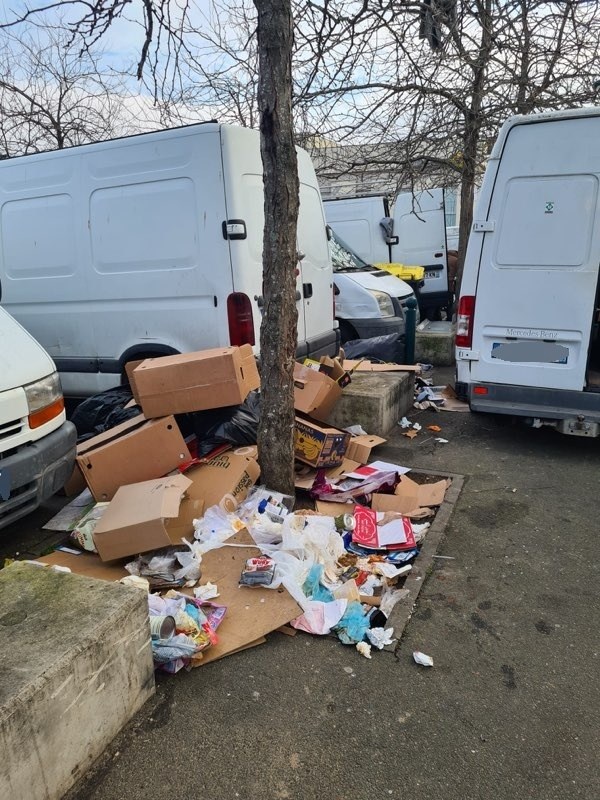

In [36]:
type(open("../assets/egoblur_demo/mantes (18).jpg", "rb"))
import io
def display_image(image : bytes):
    return Image.open(io.BytesIO(image))

display_image(open("../assets/egoblur_demo/mantes (18).jpg", "rb").read())

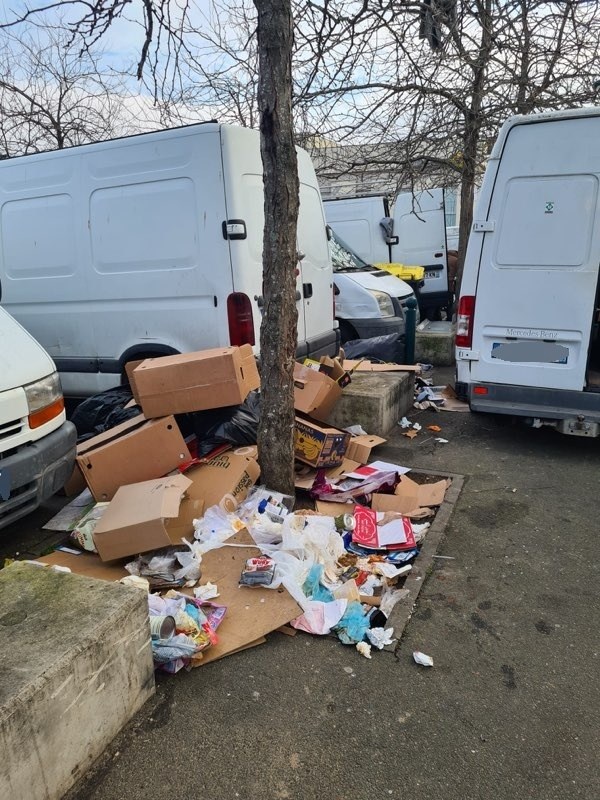

In [15]:
Image.open("../assets/egoblur_demo/mantes (18).jpg")

In [17]:
def upload_file(image_path):
    url = "https://api.baserow.io/api/user-files/upload-file/"
    files = {
        "file": open(image_path, "rb")
    }
    return make_req(url, method="POST", files=files)


f = upload_file("assets/egoblur_demo/mantes (18).jpg")
print(json.dumps(f, indent=4, sort_keys=True))

{
    "image_height": 800,
    "image_width": 600,
    "is_image": true,
    "mime_type": "image/jpeg",
    "name": "BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg",
    "original_name": "mantes (18).jpg",
    "size": 236070,
    "thumbnails": {
        "card_cover": {
            "height": 160,
            "url": "https://baserow-media.ams3.digitaloceanspaces.com/thumbnails/card_cover/BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg",
            "width": 300
        },
        "small": {
            "height": 48,
            "url": "https://baserow-media.ams3.digitaloceanspaces.com/thumbnails/small/BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg",
            "width": 48
        },
        "tiny": {
            "height": 21,
            "url": "https://baserow-media.ams3.digitaloceanspaces.com/thumbnails/tiny/BElTRAIFyHR3Nh9

In [18]:
Image(url=f["url"])

### Generate description

with vision model we can generate a description of the image

In [19]:
def download(url: str, name: str, output_dir: str):
    r = requests.get(url, allow_redirects=True)
    if r.status_code != 200:
        raise Exception(f"Failed to download {url} to {name}")
    if r.ok:
        ext = url.split('.')[-1]
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        file_path = f"{output_dir}/{name}.{ext}"
        with open(file_path, 'wb') as f:
            f.write(r.content)
            print(f"> Downloaded {url} to {file_path}")

        return file_path
    else:
        return None

In [16]:
# todo, soit plus cool, avec des emojis
VIZ_MODEL_PROMPT = "what do you see in this picture? Generate a description of no more than 50 words. If you see garbage, please specify all the type of garbage you see. A simple but complete answer in French."
output_desc = replicate.run(
    "yorickvp/llava-13b:e272157381e2a3bf12df3a8edd1f38d1dbd736bbb7437277c8b34175f8fce358",
    input={
        "file": ("image test", open("../assets/egoblur_demo/mantes (18).jpg", "rb")),
        "top_p": 1,
        "prompt": VIZ_MODEL_PROMPT,
        "max_tokens": 120,
        "temperature": 0.2
    }
)

" ".join(output_desc)

ReplicateError: - input: image is required


In [24]:

def generate_description(image_path: str):
    model_name: str = "yorickvp/llava-13b:e272157381e2a3bf12df3a8edd1f38d1dbd736bbb7437277c8b34175f8fce358"

    # todo, soit plus cool, avec des emojis
    VIZ_MODEL_PROMPT = "what do you see in this picture? Generate a description of no more than 50 words. If you see garbage, please specify all the type of garbage you see. A simple but complete answer in French."
    output_desc = replicate.run(
        model_name,
        input={
            "image": image_path,
            "top_p": 1,
            "prompt": VIZ_MODEL_PROMPT,
            "max_tokens": 120,
            "temperature": 0.2
        }
    )
    return " ".join(output_desc)


output_desc = generate_description(f["url"])
output_desc

"Il  y  a  un  tas  de  cartons  et  de  déchets  dans  un  parking.  Il  y  a  des  cartons  de  pizza,  des  boîtes  de  pizza,  des  boîtes  de  carton,  des  sacs  de  poubelle,  des  journaux,  des  bouteilles,  des  cartes  de  crédit  et  des  cartes  de  visite.  Les  déchets  sont  entassés  autour  d'un  arbre  et  de  plusieurs  vans."

In [32]:
classes_names_ids_map

{1212363: '0',
 1212364: '1',
 1212365: '2',
 1213481: '3',
 1213482: '4',
 1213483: '5',
 1213484: '6',
 1213485: '7',
 1213486: '8',
 1213487: '9',
 1213488: '10'}

In [33]:
from pydantic import BaseModel, Field

class DetectedDechet(BaseModel):
    photo: List[dict] = Field(..., description="List of photos.")
    cat_idx_preds: Optional[List[int]] = Field(..., description="List of classes names.")
    cat_idx_occurences: dict = Field(..., description="Occurences of each class.")
    long: str = Field(..., description="Longitude.")
    lat: str = Field(..., description="Latitude.")
    status: str = Field("1", description="Status.")
    description: Optional[str] = Field(None, description="Description.")
    capture_date: datetime = Field(default_factory=datetime.now, description="Date de la détection.")
    
row_test = DetectedDechet(
    photo=[{"name": "oijtre"}],
    cat_idx_preds=[0, 1, 2, 3],
    cat_idx_occurences={0: 1, 1: 2, 2: 3, 3: 4},
    long="2.3",
    lat="48.8",
    status="1",
   
)

row_test.model_dump()

{'photo': [{'name': 'oijtre'}],
 'cat_idx_preds': [0, 1, 2, 3],
 'cat_idx_occurences': {0: 1, 1: 2, 2: 3, 3: 4},
 'long': '2.3',
 'lat': '48.8',
 'status': '1',
 'description': None,
 'capture_date': datetime.datetime(2024, 1, 19, 16, 54, 13, 275569)}

In [37]:
str(json.dumps({0: 1, 1: 2, 2: 3, 3: 4})

'{"0": 1, "1": 2, "2": 3, "3": 4}'

In [38]:
"serialize datetime now"
datetime.now().isoformat()

'2024-01-19T17:33:59.319168'

In [35]:
from tqdm import tqdm
from typing import List, Dict


def create_row(image_path: str, classes_names: List[int], long: str, lat: str, status: str = "1"):
    # verify if image_path is a valid path
    if not os.path.isfile(image_path):
        raise Exception("Error!", f"{image_path} is not a valid path")

    pbar = tqdm(total=4)
    # 1. Upload file
    pbar.set_description("Uploading file...")
    image_uploaded = upload_file(image_path)
    pbar.update(1)

    # 2. Generate description
    pbar.set_description("Generating description...")
    description = generate_description(image_uploaded["url"])
    pbar.update(1)

    # 3. Get name : str to id : int 
    pbar.set_description("Getting classes ids...")
    classes_ids = [classes_ids_names_map[classes_name] for classes_name in classes_names]
    pbar.update(1)

    json = {
        "photo": [
            {
                "name": image_uploaded["name"],
            }
        ],
        "classes_names": classes_ids,
        "long": long,
        "lat": lat,
        #"status": 1,
        "description": description,
    }
    print(json)

    # 4. Create row
    pbar.set_description("Creating row...")
    url = "https://api.baserow.io/api/database/rows/table/234485/?user_field_names=true"

    response = make_req(url, method="POST", json=json, headers={"Content-Type": "application/json"})
    pbar.update(1)
    return response


from datetime import datetime

YYYYMMDDHHMM = datetime.now().strftime("%Y%m%d%H%M")
create_row(image_path="assets/egoblur_demo/mantes (18).jpg", classes_names=["1", "0", "9", "8"], long="2.3", lat="48.8")


Creating row...:  75%|███████▌  | 3/4 [00:05<00:02,  2.81s/it]       

{'photo': [{'name': 'BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg'}], 'classes_names': [1212364, 1212363, 1213487, 1213486], 'long': '2.3', 'lat': '48.8', 'description': 'Il  y  a  un  tas  de  cartons  et  de  déchets  sur  le  trottoir.  Il  y  a  également  des  sacs  noirs  et  des  sacs  plastiques.'}



Creating row...: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


{'id': 18,
 'order': '18.00000000000000000000',
 'name': 'ce32363d-7852-4054-b8b7-da162be3ef35',
 'photo': [{'url': 'https://baserow-media.ams3.digitaloceanspaces.com/user_files/BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg',
   'thumbnails': {'tiny': {'url': 'https://baserow-media.ams3.digitaloceanspaces.com/thumbnails/tiny/BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg',
     'width': None,
     'height': 21},
    'small': {'url': 'https://baserow-media.ams3.digitaloceanspaces.com/thumbnails/small/BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg',
     'width': 48,
     'height': 48},
    'card_cover': {'url': 'https://baserow-media.ams3.digitaloceanspaces.com/thumbnails/card_cover/BElTRAIFyHR3Nh9ySUqnS3vuzkicPdEK_1527c71e999a2bb782723649859cb360611085f6640bc5a36fade930f4cd40af.jpg',
     'width': 300,
     'height': 160}}